In [ ]:
from google.colab import output as ooo

import cv2
import os
import sys
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

ooo.clear()

In [ ]:
from tqdm.auto import tqdm

In [ ]:
def merge_channels(input_dir, output_dir):
    with open(os.path.join(input_dir, 'image_counter.txt')) as file:
        n = int(file.readline())
    df = pd.read_csv(os.path.join(input_dir, 'description.csv'))
    for index in tqdm(set(df['full_image_index'])):
        image = []
        colors = []
        for color in ['b', 'g', 'r']:
            path_name = df[(df['full_image_index'] == index) & (df['color'] == color)]['image_path']
            path_name = path_name.tolist()[0]
            path = os.path.join(input_dir, f'data/{path_name}')
            colors.append(cv2.imread(os.path.join(input_dir, path), 0))
        shape = colors[0].shape
        image = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)
        for i in range(3):
            image[:, :, i] = colors[i]
        r = path_name[path_name.rfind('.'):]
        path_name = path_name[:path_name.rfind('.') - 2]
        cv2.imwrite(os.path.join(output_dir, path_name + r), image)

In [ ]:
merge_channels('/content/drive/MyDrive/python_split_image_by_ch', '/content/drive/MyDrive/cv1_output')

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5m')

In [ ]:
model.names

In [ ]:
from pathlib import Path

def find_car(input_dir, output_cars ='output.csv'):
    model = torch.hub.load('ultralytics/yolov5', 'yolov5m')
    model.classes = [2, 5, 7]
    filenames = []
    results = []
    with open(os.path.join(input_dir, 'image_counter.txt')) as file:
        n = int(file.readline())
    df = pd.read_csv(os.path.join(input_dir, 'description.csv'))
    for index in tqdm(set(df['full_image_index'])):
        image = []
        colors = []
        for color in ['b', 'g', 'r']:
            path_name = df[(df['full_image_index'] == index) & (df['color'] == color)]['image_path']
            path_name = path_name.tolist()[0]
            path = os.path.join(input_dir, f'data/{path_name}')
            colors.append(cv2.imread(os.path.join(input_dir, path), 0))
        shape = colors[0].shape
        image = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)
        for i in range(3):
            image[:, :, i] = colors[i]
        r = path_name[path_name.rfind('.'):]
        path_name = path_name[:path_name.rfind('.') - 2]
        result = model(image)
        results.append(True if len(result.xywh[0]) > 0 else False)
        filenames.append(path_name + r)
    path = Path(output_cars)
    path.parent.mkdir(parents=True, exist_ok=True)  
    df = pd.DataFrame({'filenames': filenames, 'car on image': results})
    df.to_csv(path)


In [ ]:
find_car('/content/drive/MyDrive/python_split_image_by_ch', '/content/drive/MyDrive/cv2_output.csv')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-6-18 Python-3.7.13 torch-1.11.0+cu113 CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients
Adding AutoShape... 


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/cv2_output.csv')
df2 = pd.read_csv('/content/drive/MyDrive/python_split_image_by_ch/val.csv')

In [ ]:
k = 1
for name in df2['00001.jpg']:
    res1 = df2[df2['00001.jpg'] == name]['False'].tolist()[0]
    res2 = df1[df1['filenames'] == name]['car on image'].tolist()[0]
    if res1 == res2:
        k += 1
    else:
        print(res1, res2, name)

print(k)

100


In [ ]:
print(max(0, k - 60) * 20 / (100 - 60))

20.0


In [ ]:
!pip install colorthief

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scipy.cluster.vq import whiten, kmeans
from collections import Counter
from PIL import Image
from IPython.display import display
from google.colab.patches import cv2_imshow


def calc_metric(image, x, y, w, h, visualize=False):
    image = cv2.imread(image)
    image = image[y + int(h / 6):y + h - int(h / 6), x + int(w / 6):x + w - int(w / 6)]
    mx = 180
    if h < w:
        nw = min(mx, w)
        image = cv2.resize(image, (nw, int(nw / w * h)))
    else:
        nh = min(mx, h)
        image = cv2.resize(image, (int(nh / h * w), nh))
    shape = image.shape
    n = shape[0] * shape[1]
    colors = image.reshape((n, 3))
    mn = float('inf')
    colors = colors.astype(np.int64)
    ans = []
    for r in range(15, 256, 16):
        for g in range(15, 256, 16):
            for b in range(15, 256, 16):
                color = list(map(lambda z: z - 8, [r, g, b]))
                rr, gg, bb = tuple(color)
                color = sum([np.power(colors[:, i] - color[i], 2) for i in range(3)])
                color.sort()
                color = np.sum(color[:int(n * 0.4)])
                ans.append((color, (rr, gg, bb)))
    anses = list(sorted(ans, key=lambda z: z[0]))[:3]
    ans = anses[1][1]
    if visualize:
        cv2_imshow(image)
        holst = np.zeros((shape[0], shape[1], 3))
        color = np.array(ans)
        holst[:, :] += color
        holst.astype(np.uint8)
        cv2_imshow(holst)
    return anses


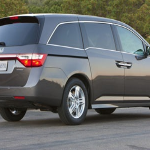

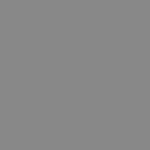

In [ ]:
colors = calc_metric('/content/drive/MyDrive/cv1_output/00010.jpg', 0, 0, 500, 500, visualize=True)

In [ ]:
from pathlib import Path


In [ ]:
!pip install webcolors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import webcolors

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[name] = (rd + gd + bd)
    mn_colors = {}
    for color in ['red', 'green', 'blue', 'black', 'white', 'yellow']:
        if color in min_colours.keys():
            z = min_colours[color]
            mn_colors[z] = color
    return mn_colors[min(mn_colors.keys())], z

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

In [ ]:
import colorsys

def find_color(input_dir, output_file="output_color.csv"):
    model = torch.hub.load('ultralytics/yolov5', 'yolov5m')
    model.classes = [2, 5, 7]
    color_dict = {'red': 'red', 'green': 'green', 'blue': 'blue_cyan',
                  'black': 'black', 'white': 'white_silver', 'yellow': 'yellow'}
    filenames = []
    coloring = []
    results = []
    with open(os.path.join(input_dir, 'image_counter.txt')) as file:
        n = int(file.readline())
    df = pd.read_csv(os.path.join(input_dir, 'description.csv'))
    for index in tqdm(list(set(df['full_image_index']))):
        image = []
        colors = []
        for color in ['b', 'g', 'r']:
            path_name = df[(df['full_image_index'] == index) & (df['color'] == color)]['image_path']
            path_name = path_name.tolist()[0]
            path = os.path.join(input_dir, f'data/{path_name}')
            colors.append(cv2.imread(os.path.join(input_dir, path), 0))
        shape = colors[0].shape
        image = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)
        for i in range(3):
            image[:, :, i] = colors[i]
        r = path_name[path_name.rfind('.'):]
        path_name = path_name[:path_name.rfind('.') - 2]
        result = model(image).xywh[0]
        result = [result[i].numpy() for i in range(len(result))]
        x, y, w, h, *_ = list(sorted(result, key=lambda x: x[4]))[-1]
        x, y, w, h = [int(i) for i in [x, y, w, h]]
        x = int(x - w / 2)
        y = int(y - y / 2)
        Image.fromarray(image).save(os.path.join(input_dir, 'rrr' + r))
        colorsss = calc_metric(os.path.join(input_dir, 'rrr' + r), x, y, w, h, visualize=False)
        res = []
        for i in range(3):
            c_a, c_c = get_colour_name(colorsss[i][1])
            if c_a is not None:
                res.append((color_dict[c_a[0]], c_a[1]))
            else:
                res.append((color_dict[c_c[0]], c_c[1]))
        res = list(sorted(res, key=lambda x: x[1]))[0][0]
        results.append(res)
        filenames.append(path_name + r)

    path = Path(output_file)
    path.parent.mkdir(parents=True, exist_ok=True)  
    df = pd.DataFrame({'filenames': filenames, 'car on image': results})
    df.to_csv(path)
    return df

In [ ]:
res = find_color('/content/drive/MyDrive/color_cars_train', '/content/drive/MyDrive/cv4_output.csv')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-6-18 Python-3.7.13 torch-1.11.0+cu113 CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients
Adding AutoShape... 


  0%|          | 0/96 [00:00<?, ?it/s]

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/color_cars_train/colors.csv')
df2 = pd.read_csv('/content/drive/MyDrive/cv4_output.csv')

In [ ]:
df1[df1['00001.jpg'] == '00015.jpg']

,00001.jpg,yellow
13,00015.jpg,green


In [ ]:
df1[df1['00001.jpg'] == '00003.jpg']['yellow'].tolist()[0]

'green'

In [ ]:
df1

In [ ]:
df2

In [ ]:
k = 0
for name in df1['00001.jpg']:
    if df1[df1['00001.jpg'] == name]['yellow'].tolist()[0] == df2[df2['filenames'] == name]['car on image'].tolist()[0]:
        k += 1

In [ ]:
n = 95

In [ ]:
k

49

In [ ]:
max(0, k - 0.2 * n) * 40 / (n - 0.2 * n)

15.789473684210526

In [ ]:
image = cv2.imread('/content/drive/MyDrive/cv4_images/00025.jpg')

## функция для обработки обрезанного изображения с машиной
она будет смотреть на пиксели в формате (hsv)

In [ ]:
def get_hsv_info_from_car_im(image, x, y, w, h):
    im = image[y + h // 11:y + h - h // 11, x + w // 11:x + w - w // 11]
    hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    
    HSV_min = np.array([0, 60, 120])
    HSV_max = np.array([155,190,240])

    mask = cv2.inRange(hsv, HSV_min, HSV_max)
    result = cv2.bitwise_and(im, im, mask=mask)

    gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(gray_result, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 115 < area < 205:
            return 'On'
    return 'Off'
    

    brake_light = []

In [ ]:
def check_stop_signals(input_dir, output_file="output_color.csv"):
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
    model.classes = [2, 5, 7]
    filenames = []
    coloring = []
    results = []
    with open(os.path.join(input_dir, 'image_counter.txt')) as file:
        n = int(file.readline())
    df = pd.read_csv(os.path.join(input_dir, 'description.csv'))
    for index in tqdm(list(set(df['full_image_index']))):
        image = []
        colors = []
        for color in ['b', 'g', 'r']:
            path_name = df[(df['full_image_index'] == index) & (df['color'] == color)]['image_path']
            path_name = path_name.tolist()[0]
            path = os.path.join(input_dir, f'data/{path_name}')
            colors.append(cv2.imread(os.path.join(input_dir, path), 0))
        shape = colors[0].shape
        image = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)
        for i in range(3):
            image[:, :, i] = colors[i]
        r = path_name[path_name.rfind('.'):]
        path_name = path_name[:path_name.rfind('.') - 2]
        all_res = model(image).xywh
        ans = 'no_cars' if len(all_res) == 0 else 'Off'
        for i in range(len(all_res)):
            result = all_res[0]
            if len(result) > 0:
                result = [result[i].numpy() for i in range(len(result))]
                x, y, w, h, p, k = list(sorted(result, key=lambda x: x[4]))[-1]
                if p > 0.04:
                    x, y, w, h = [int(i) for i in [x, y, w, h]]
                    x = int(x - w / 2)
                    y = int(y - h / 2)
                    res_iter = get_hsv_info_from_car_im(image, x, y, w, h)
                    if res_iter == 'On':
                        ans = 'On'
                        break
                else:
                    ans = 'no_cars'
            else:
                ans = 'no_cars'
        results.append(ans)
        filenames.append(path_name + r)
        
 
    path = Path(output_file)
    path.parent.mkdir(parents=True, exist_ok=True)  
    df = pd.DataFrame({'filenames': filenames, 'car on image': results})
    df.to_csv(path)
    return df

In [ ]:
check_stop_signals('/content/drive/MyDrive/stop_signals', 'cv5_output.csv')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-6-18 Python-3.7.13 torch-1.11.0+cu113 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


  0%|          | 0/100 [00:00<?, ?it/s]

,filenames,car on image
0,00001.jpg,no_cars
1,00002.jpg,On
2,00003.jpg,Off
3,00004.jpg,On
4,00005.jpg,Off
...,...,...
95,00096.jpg,no_cars
96,00097.jpg,no_cars
97,00098.jpg,Off
98,00099.jpg,On


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/stop_signals/train.csv')
df2 = pd.read_csv('/content/cv5_output.csv')

In [ ]:
df1 = df1.rename(columns={'00001.jpg': 'filenames', 'no_cars': 'car on image'})
df_ = pd.DataFrame({'filenames': ['00001.jpg'], 'car on image': ['no_cars']})
df1 = df1.append(df_)
df1 = df1.reset_index()

In [ ]:
points_on = df2[(df1['car on image'] == 'On') & (df2['car on image'] != 'NOT')]['car on image'].tolist()
points_off = df2[(df1['car on image'] == 'Off') & (df2['car on image'] != 'NOT')]['car on image'].tolist()
point_no_car_my = set(df2[df2['car on image'] == 'NOT']['filenames'].tolist())
point_car_my = set(df2[df2['car on image'] != 'NOT']['filenames'].tolist())
point_no_car = set(df1[df1['car on image'] == 'no_cars']['filenames'].tolist())
point_car = set(df1[df1['car on image'] != 'no_cars']['filenames'].tolist())


plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [ ]:
k = 0
d = {}
for name in set(df1['filenames'].tolist()):
    ans1 = df1[df1['filenames'] == name]['car on image'].tolist()[0]
    ans2 = df2[df2['filenames'] == name]['car on image'].tolist()[0]
    if ans1 == ans2:
        k += 1
    else:
        d[name] = (ans1, ans2)
n = len(set(df1['filenames'].tolist()))

In [ ]:
k

75

In [ ]:
v = list(d.values())

In [ ]:
v.count(('On', 'Off')), v.count(('Off', 'On'))

(10, 11)

In [ ]:
max(0, k - 0.6 * n) * 50 / (n - 0.6 * n)

18.75

In [ ]:
d

{'00002.jpg': ('Off', 'On'),
 '00016.jpg': ('Off', 'On'),
 '00018.jpg': ('Off', 'On'),
 '00022.jpg': ('Off', 'On'),
 '00023.jpg': ('Off', 'On'),
 '00026.jpg': ('no_cars', 'On'),
 '00031.jpg': ('On', 'Off'),
 '00037.jpg': ('Off', 'On'),
 '00041.jpg': ('On', 'Off'),
 '00042.jpg': ('On', 'Off'),
 '00043.jpg': ('On', 'Off'),
 '00045.jpg': ('Off', 'On'),
 '00047.jpg': ('On', 'Off'),
 '00049.jpg': ('no_cars', 'Off'),
 '00050.jpg': ('On', 'Off'),
 '00053.jpg': ('On', 'Off'),
 '00054.jpg': ('On', 'Off'),
 '00058.jpg': ('Off', 'On'),
 '00071.jpg': ('Off', 'On'),
 '00072.jpg': ('On', 'Off'),
 '00074.jpg': ('On', 'no_cars'),
 '00089.jpg': ('Off', 'On'),
 '00092.jpg': ('On', 'no_cars'),
 '00098.jpg': ('On', 'Off'),
 '00099.jpg': ('Off', 'On')}

In [ ]:
im = cv2.imread('/content/drive/MyDrive/cv5_images/00016.jpg')

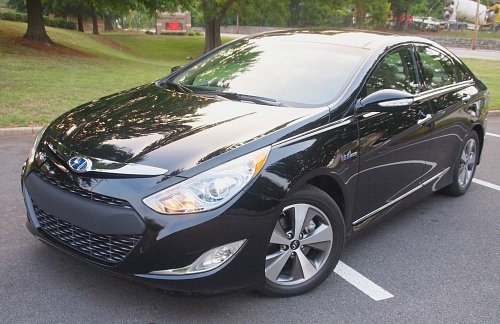

In [ ]:
cv2_imshow(im)

In [ ]:
hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

HSV_min = np.array([0, 60, 120])
HSV_max = np.array([160,200,255])

mask = cv2.inRange(hsv, HSV_min, HSV_max)
result = cv2.bitwise_and(im, im, mask=mask)

gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

contours, hierarchy = cv2.findContours(gray_result, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    area = cv2.contourArea(cnt)
    if 120 < area < 210:
        print(area)